A key assumption of most unsupervised denoising methods is that noise has to be uncorrelated pixel wise. I this notebook I investigate for which axes this assumption makes sense at all.

# Conclusions of this analyis:

### 1. Noise in the x,y,z plane is strongly correlated, breaking unsupervised denoising assumptions

### 2. Noise in (t,T) and (f,T) is highly uncorrelated, making noise 2 void / noise 2 self a valid approach

### 3. After low rank noise also becomes correlated in (t,T) of (f,T), therefore applying noise 2 void after low rank does not work

### 4. There even is a lag correlation in (f,T) between low rank and full rank data, that means a ynet approach with one low rank path (even if the pixels are masked in the

### same way as the full rank data) is meaningless: The surrounding pixels now even carry noise information about the noise in the masked full rank pixel!!

### 5. The only legitimate approach to use low rank, is to apply it AFTER noise 2 void, any contribution of low rank breaks the assumptions of noise 2 void

### 6. Add on: The pixel must never be replaced with itself, otherwise the network will start to produce noisy output at some point, as it is rewarded for reproducing noise from time to time (identity is optimal if the pixel is replaced with itself)

### 7. You have to mask real and imaginary channels simultaneously at the masked 

### 8. There is no point in applying low rank after noise 2 void: It does not change the fits at all!

In [1]:
import numpy as np
from numpy.fft import fft2, ifft2, fftshift
from scipy.stats import norm
import matplotlib.pyplot as plt

#### Choose volunteer for computing noise statistics

Vol = 'P03'

#### Load data



def low_rank_5d(data, rank):
    """
    Computes a low-rank decomposition of a tensor with shape (22, 22, 21, 96, 8)
    using truncated SVD.

    Args:
        data (np.ndarray): Numpy array of shape (x, y, z, t, T).
        rank (int): The number of singular values to keep (final rank).

    Returns:
        np.ndarray: The reconstructed tensor with rank 'rank'.
    """

    # Unpack dimensions
    x, y, z, t, T = data.shape
    
    # Reshape the 5D tensor into a 2D matrix of shape (x*y*z, t*T)
    # Use 'F' (Fortran) order to match MATLAB's column-major ordering
    reshaped_matrix = data.reshape((x * y * z, t * T), order='F')
    
    # Perform economy-size SVD (similar to MATLAB's "svd(..., 'econ')")
    U, singular_values, Vh = np.linalg.svd(reshaped_matrix, full_matrices=False)
    
    # Truncate the singular values to the desired rank
    k = min(rank, len(singular_values))  # safeguard: rank cannot exceed # of singular values
    singular_values_truncated = np.zeros_like(singular_values)
    singular_values_truncated[:k] = singular_values[:k]
    
    # Form the diagonal matrix of truncated singular values
    S_truncated = np.diag(singular_values_truncated)
    
    # Reconstruct the matrix using the truncated SVD components
    reconstructed_matrix = U @ S_truncated @ Vh
    
    # Reshape back to the original 5D shape, again using 'F' order
    reconstructed_tensor = reconstructed_matrix.reshape((x, y, z, t, T), order='F')
    
    return reconstructed_tensor

def low_rank(data: np.ndarray, rank: int) -> np.ndarray:
    """
    Computes a low-rank decomposition of a tensor with shape
      • (x, y, z, t, T)  → direkt per SVD
      • (x, y, z, t, T, D) → wendet SVD separat auf jede D-Scheibe an

    Args:
        data (np.ndarray): Eingabe mit 5 oder 6 Dimensionen.
        rank (int): Anzahl der Singulärwerte.

    Returns:
        np.ndarray: Rekonstruiertes Array in Original-Shape.
    """
    if data.ndim == 5:
        # Einzelfall: direkt 5D
        return low_rank_5d(data, rank)

    elif data.ndim == 6:
        # 6D: Apply low_rank_5d für jede D-Scheibe
        x, y, z, t, T, D = data.shape
        rec = np.zeros_like(data)
        for d in range(D):
            rec[..., d] = low_rank_5d(data[..., d], rank)
        return rec

    else:
        raise ValueError(f"low_rank expects 5 or 6 dims, got {data.ndim}")


mask = np.load(f'../datasets/{Vol}/mask.npy')

data = np.load(f'../datasets/{Vol}/data.npy')

data_LR8 = low_rank_5d(data, 10)

In [9]:
data_fT = np.fft.fftshift(np.fft.fft(data, axis=-2), axes=-2)
data_fT_LR8 = np.fft.fftshift(np.fft.fft(data_LR8, axis=-2), axes=-2)

# Define functions

In [2]:


# ---------------------------------------------------------------------
# Hilfs-Funktionen
# ---------------------------------------------------------------------
def _center(img):
    """Ziehe globalen Mittelwert ab (float32 für Stabilität)."""
    return img.astype(np.float32) - img.mean(dtype=np.float64)

# ---------------------------------------------------------------------
# 2-D Autokorrelation (für 2-D oder 3-D Stack)
# ---------------------------------------------------------------------
def compute_2d_autocorrelation(noise: np.ndarray) -> np.ndarray:
    """
    2-D ACF eines Noise-Bildes oder Mittel-ACF mehrerer Bilder.
    
    Args
    ----
    noise : np.ndarray
        - Shape (F, T)   -> Einzelbild
        - Shape (N, F, T)-> Stapel von Noise-Bildern
    
    Returns
    -------
    np.ndarray
        Mittlere 2-D-Autokorrelationskarte, zentriert & auf 1 normiert.
    """
    if noise.ndim == 2:                    # Einzelbild
        imgs = noise[None]                 # → (1, F, T)
    elif noise.ndim == 3:                  # Stapel
        imgs = noise
    else:
        raise ValueError("noise must be 2-D (F,T) or 3-D (N,F,T)")

    ac_sum = None
    for img in imgs:
        x = _center(img)
        ps = fft2(x) * np.conj(fft2(x))
        ac  = ifft2(ps).real
        ac  = fftshift(ac)
        if ac_sum is None:
            ac_sum = ac
        else:
            ac_sum += ac

    ac_mean = ac_sum / len(imgs)
    return ac_mean / np.max(np.abs(ac_mean))

# ---------------------------------------------------------------------
# 1-D Lag-Korrelation (für 2-D oder 3-D Stack)
# ---------------------------------------------------------------------
def compute_lag_correlation(noise: np.ndarray,
                            axis: int,
                            max_lag: int = 20):
    """
    1-D Lag-Korrelation entlang einer Achse, gemittelt über mehrere Bilder.
    
    axis = 0  → Freq-Lag   (über Zeit gemittelt)
    axis = 1  → Time-Lag   (über Frequenz gemittelt)
    """
    if noise.ndim == 2:
        imgs = noise[None]                 # → (1, F, T)
    elif noise.ndim == 3:
        imgs = noise
    else:
        raise ValueError("noise must be 2-D or 3-D")

    # Dimensionen
    F, T = imgs.shape[-2:]
    L = (F if axis == 0 else T)
    ML = min(max_lag, L - 1)
    lags  = np.arange(ML + 1)
    corr  = np.zeros_like(lags, dtype=np.float64)
    n_tot = np.zeros_like(lags, dtype=np.int64)

    for img in imgs:
        x   = _center(img)
        var = x.var(dtype=np.float64)

        for i, k in enumerate(lags):
            if axis == 0:  # Freq-Lag
                a, b = x[0:F-k, :], x[k:F, :]
            else:          # Time-Lag
                a, b = x[:, 0:T-k], x[:, k:T]

            prod = (a * b).mean()
            n_pairs = a.size
            corr[i] += prod / var          # Summe über Bilder
            n_tot[i] += n_pairs

    corr /= len(imgs)                      # Mittelwert über Bilder
    return lags, corr, n_tot

# ---------------------------------------------------------------------
# Konfidenzband ±z/√N
# ---------------------------------------------------------------------
def confidence_band(n_pairs: np.ndarray,
                    alpha: float = 0.05) -> np.ndarray:
    z = norm.ppf(1 - alpha / 2)            # ≈ 1.96 für 95 %
    band = z / np.sqrt(n_pairs.astype(np.float64))
    band[np.isinf(band)] = np.nan
    return band

def plot_noise_correlation_analysis(
    noise, x_label="Time", y_label="Freq",
    max_lag_x=20, max_lag_y=20,
):
    """
    Visualisiere:
      1. 2D Autokorrelationskarte
      2. Lag-Korrelation entlang X-Achse (axis=1 → x_label)
      3. Lag-Korrelation entlang Y-Achse (axis=0 → y_label)

    Args:
        noise: Array mit Shape (N,F,T) oder (F,T)
        x_label: Label für X-Achse (z. B. "Time")
        y_label: Label für Y-Achse (z. B. "Freq")
        max_lag_x: Maximale Verzögerung entlang x-Achse
        max_lag_y: Maximale Verzögerung entlang y-Achse
    """

    # --- Statistische Ausgabe ---
    noise_flat = noise.reshape(-1)  # alles zu einem Vektor
    mean = np.mean(noise_flat)
    std = np.std(noise_flat)
    print(f"Noise mean: {mean:.4e}, std: {std:.4e}")
    
    # 2D-Autokorrelation
    acf2d = compute_2d_autocorrelation(noise)

    # 1D-Lag-Korrelationen
    lags_x, corr_x, n_x = compute_lag_correlation(noise, axis=1, max_lag=max_lag_x)
    lags_y, corr_y, n_y = compute_lag_correlation(noise, axis=0, max_lag=max_lag_y)
    band_x = confidence_band(n_x)
    band_y = confidence_band(n_y)

    # --- Plot ---
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))

    # 1) 2D Autokorrelation
    im = axs[0].imshow(acf2d, cmap="viridis", aspect="auto")
    axs[0].set_title(f"2D Autokorrelation ({y_label} × {x_label})")
    axs[0].set_xlabel(f"{x_label}-Index")
    axs[0].set_ylabel(f"{y_label}-Index")
    plt.colorbar(im, ax=axs[0])

    # 2) Lag-Korrelation entlang y-Achse (axis=0)
    axs[1].plot(lags_y, corr_y, "o-", label=f"{y_label}-Lag")
    axs[1].fill_between(lags_y, corr_y - band_y, corr_y + band_y, alpha=0.2, color="gray")
    axs[1].axhline(0, color="k", lw=0.5)
    axs[1].set_xlabel("Lag")
    axs[1].set_ylabel("Korrelation")
    axs[1].set_title(f"Lag-Korrelation ({y_label}) ±95% CI")
    axs[1].grid(True)

    # 3) Lag-Korrelation entlang x-Achse (axis=1)
    axs[2].plot(lags_x, corr_x, "s-", label=f"{x_label}-Lag")
    axs[2].fill_between(lags_x, corr_x - band_x, corr_x + band_x, alpha=0.2, color="gray")
    axs[2].axhline(0, color="k", lw=0.5)
    axs[2].set_xlabel("Lag")
    axs[2].set_ylabel("Korrelation")
    axs[2].set_title(f"Lag-Korrelation ({x_label}) ±95% CI")
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()

def compute_lag_cross_correlation(
    noise_x: np.ndarray,
    noise_y: np.ndarray,
    axis: int,
    max_lag: int = 20
):
    """
    Berechnet die 1-D Lag-Korrelation zwischen zwei Noise-Stacks entlang der
    angegebenen Achse. Analog zu `compute_lag_correlation`, aber für zwei
    verschiedene Zufallsvariablen (noise_x, noise_y).

    Args:
        noise_x: Array mit Shape (N,F,T) oder (F,T)
        noise_y: Array mit Shape (N,F,T) oder (F,T) – gleiche Shape wie noise_x
        axis   : 0 → Freq-Lag, 1 → Time-Lag
        max_lag: maximale Verzögerung

    Returns:
        lags   : np.ndarray der Lags (0..max_lag)
        corr   : np.ndarray der normierten Kreuzkorrelation pro Lag
        n_tot  : np.ndarray Anzahl der verwendeten Paarungen pro Lag
    """
    if noise_x.shape != noise_y.shape:
        raise ValueError("noise_x und noise_y müssen die gleiche Shape haben")

    # In 3-D (N,F,T) bringen, sonst 2-D → (1,F,T)
    if noise_x.ndim == 2:
        imgs_x = noise_x[None]
        imgs_y = noise_y[None]
    elif noise_x.ndim == 3:
        imgs_x = noise_x
        imgs_y = noise_y
    else:
        raise ValueError("noise_x/noise_y must be 2-D or 3-D")

    F, T = imgs_x.shape[-2:]
    L = (F if axis == 0 else T)
    ML = min(max_lag, L - 1)
    lags  = np.arange(ML + 1)
    corr  = np.zeros_like(lags, dtype=np.float64)
    n_tot = np.zeros_like(lags, dtype=np.int64)

    for img_x, img_y in zip(imgs_x, imgs_y):
        x = _center(img_x)
        y = _center(img_y)
        var_x = x.var(dtype=np.float64)
        var_y = y.var(dtype=np.float64)
        denom = np.sqrt(var_x * var_y)
        if denom == 0:
            raise ValueError("Varianz eines der Noise-Arrays ist 0 – Korrelation undefiniert.")

        for i, k in enumerate(lags):
            if axis == 0:  # Freq-Lag
                a, b = x[0:F-k, :], y[k:F, :]
            else:          # Time-Lag
                a, b = x[:, 0:T-k], y[:, k:T]

            prod = (a * b).mean()
            n_pairs = a.size
            corr[i] += prod / denom
            n_tot[i] += n_pairs

    corr /= len(imgs_x)
    return lags, corr, n_tot

def plot_cross_noise_correlation_analysis(
    noise_x: np.ndarray,
    noise_y: np.ndarray,
    labels: tuple[str, str] = ("Noise X", "Noise Y"),
    x_label: str = "Time",
    y_label: str = "Freq",
    max_lag_x: int = 20,
    max_lag_y: int = 20,
    show_2d: bool = True
):
    """
    Visualisiere die Kreuzkorrelation zwischen zwei Noise-Stacks analog zu
    `plot_noise_correlation_analysis`:
      1. (optional) 2D Kreuzkorrelationskarte
      2. Lag-Korrelation entlang y-Achse (axis=0)
      3. Lag-Korrelation entlang x-Achse (axis=1)

    Args:
        noise_x, noise_y: Arrays mit Shape (N,F,T) oder (F,T)
        labels          : Namen/Legendenlabel der beiden Noise-Sets
        x_label, y_label: Achsentitel
        max_lag_x/y     : maximale Lags entlang Zeit bzw. Frequenz
        show_2d         : wenn True, 2D-Karte anzeigen
    """

    # --- Statistische Ausgabe ---
    nx_flat = noise_x.reshape(-1)
    ny_flat = noise_y.reshape(-1)
    mean_x, std_x = np.mean(nx_flat), np.std(nx_flat)
    mean_y, std_y = np.mean(ny_flat), np.std(ny_flat)
    print(f"{labels[0]} mean: {mean_x:.4e}, std: {std_x:.4e}")
    print(f"{labels[1]} mean: {mean_y:.4e}, std: {std_y:.4e}")

    # --- 1D Kreuzkorrelationen ---
    lags_y, corr_y, n_y = compute_lag_cross_correlation(noise_x, noise_y, axis=0, max_lag=max_lag_y)
    lags_x, corr_x, n_x = compute_lag_cross_correlation(noise_x, noise_y, axis=1, max_lag=max_lag_x)
    band_y = confidence_band(n_y)
    band_x = confidence_band(n_x)

    if show_2d:
        fig, axs = plt.subplots(1, 3, figsize=(18, 4))
    else:
        fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    ax_idx = 0

    # (1) 2D Kreuzkorrelation
    if show_2d:
        ccf2d = compute_2d_cross_correlation(noise_x, noise_y, normalize=True)
        im = axs[ax_idx].imshow(ccf2d, cmap="viridis", aspect="auto")
        axs[ax_idx].set_title(f"2D Kreuzkorrelation ({y_label} × {x_label})")
        axs[ax_idx].set_xlabel(f"{x_label}-Index (verschoben)")
        axs[ax_idx].set_ylabel(f"{y_label}-Index (verschoben)")
        plt.colorbar(im, ax=axs[ax_idx])
        ax_idx += 1

    # (2) Lag-Korrelation entlang y-Achse (axis=0)
    axs[ax_idx].plot(lags_y, corr_y, "o-", label=f"{labels[0]} ↔ {labels[1]}")
    axs[ax_idx].fill_between(lags_y, corr_y - band_y, corr_y + band_y, alpha=0.2, color="gray")
    axs[ax_idx].axhline(0, color="k", lw=0.5)
    axs[ax_idx].set_xlabel("Lag")
    axs[ax_idx].set_ylabel("Korrelation")
    axs[ax_idx].set_title(f"Lag-Kreuzkorrelation ({y_label}) ±95% CI")
    axs[ax_idx].grid(True)
    ax_idx += 1

    # (3) Lag-Korrelation entlang x-Achse (axis=1)
    axs[ax_idx].plot(lags_x, corr_x, "s-", label=f"{labels[0]} ↔ {labels[1]}")
    axs[ax_idx].fill_between(lags_x, corr_x - band_x, corr_x + band_x, alpha=0.2, color="gray")
    axs[ax_idx].axhline(0, color="k", lw=0.5)
    axs[ax_idx].set_xlabel("Lag")
    axs[ax_idx].set_ylabel("Korrelation")
    axs[ax_idx].set_title(f"Lag-Kreuzkorrelation ({x_label}) ±95% CI")
    axs[ax_idx].grid(True)

    plt.tight_layout()
    plt.show()

def compute_2d_cross_correlation(
    noise_x: np.ndarray,
    noise_y: np.ndarray,
    normalize: bool = True
) -> np.ndarray:
    """
    2D-Kreuzkorrelationsschätzer über FFT. Normiert auf ±1 mittels Gesamt-Pixelfläche.
    """
    if noise_x.shape != noise_y.shape:
        raise ValueError("noise_x und noise_y müssen die gleiche Shape haben")

    if noise_x.ndim == 3:
        x = _center(noise_x.mean(axis=0))
        y = _center(noise_y.mean(axis=0))
    else:
        x = _center(noise_x)
        y = _center(noise_y)

    var_x = x.var(dtype=np.float64)
    var_y = y.var(dtype=np.float64)

    # FFT-basierte Kreuzkorrelation (circular)
    fx = np.fft.fft2(x)
    fy = np.fft.fft2(y)
    cc = np.fft.ifft2(fx * np.conj(fy)).real
    cc = np.fft.fftshift(cc)

    if normalize:
        n_pix = x.size
        denom = np.sqrt(var_x * var_y) * n_pix
        if denom != 0:
            cc /= denom
    return cc


# Visualize mask for finding noise regions

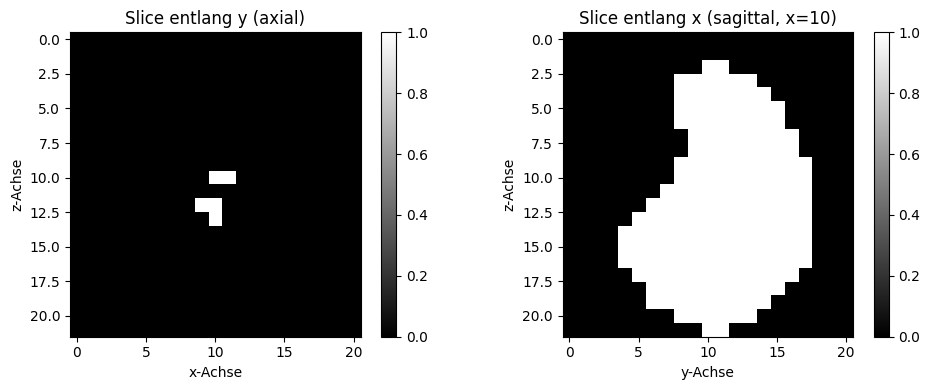

In [5]:
mask = np.load(f'../datasets/{Vol}/mask.npy')

Slice_1 = mask[:,-1,:]
Slice_2 = mask[10,:,:]

# Plot
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Slice 1
im1 = axs[0].imshow(Slice_1, cmap='gray')
axs[0].set_title("Slice entlang y (axial)")
axs[0].set_xlabel("x-Achse")
axs[0].set_ylabel("z-Achse")
fig.colorbar(im1, ax=axs[0], fraction=0.046)

# Slice 2
im2 = axs[1].imshow(Slice_2, cmap='gray')
axs[1].set_title("Slice entlang x (sagittal, x=10)")
axs[1].set_xlabel("y-Achse")
axs[1].set_ylabel("z-Achse")
fig.colorbar(im2, ax=axs[1], fraction=0.046)

plt.tight_layout()
plt.show()

# check x-z correlations - OHNE low rank

Noise mean: 2.1459e-03, std: 8.7505e-02


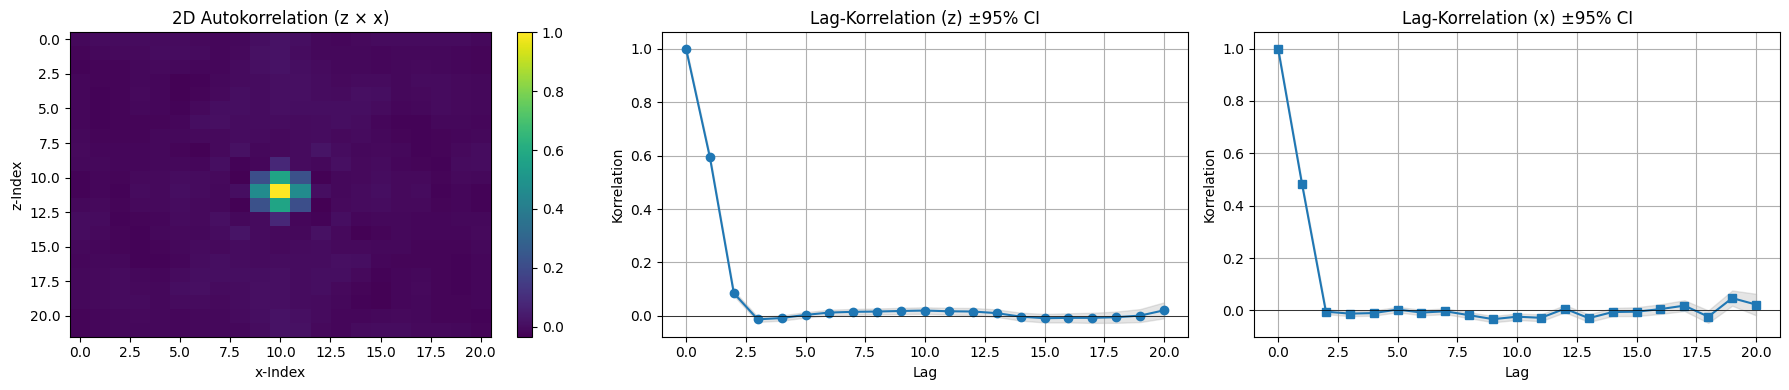

In [6]:
#### average hier über alle FID punkte > 4, für y = -1 (nur noise)

T = 0
noise = np.transpose(np.real(data[:,-1,:,5:,T]), axes=(-1,0,1))

plot_noise_correlation_analysis(
    noise, x_label="x", y_label="z",
    max_lag_x=20, max_lag_y=20,
)

# t, T correlations, OHNE low rank

Noise mean: 3.8912e-03, std: 8.8487e-02


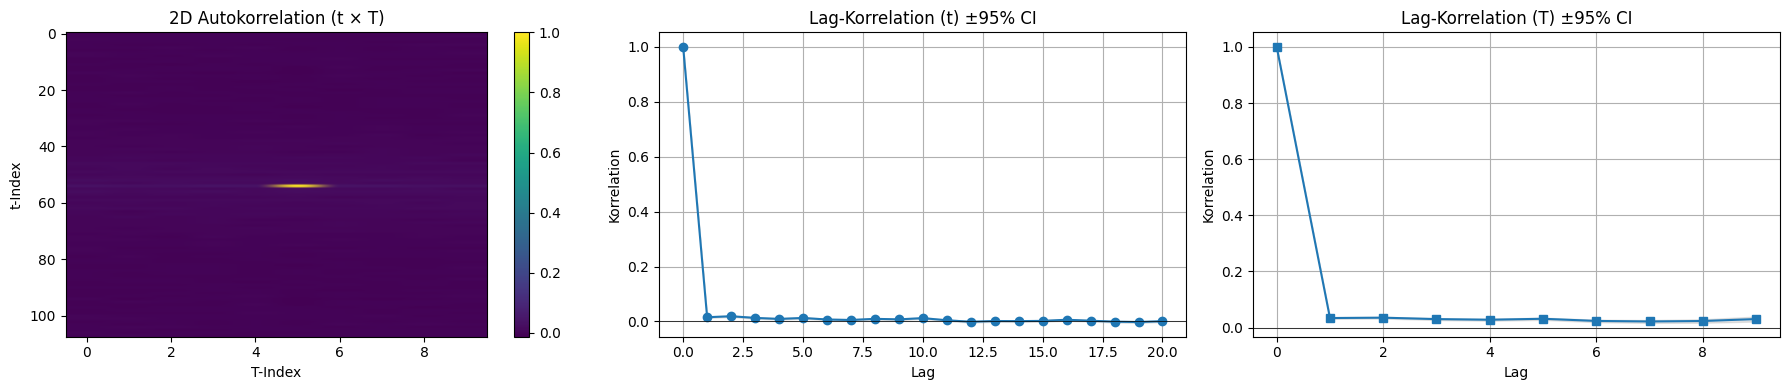

In [7]:
#### average hier über alle x-z werte für y = -1

y_idx = -1

slice_y = data[:,y_idx,...]

noise = np.real(slice_y.reshape(-1, data.shape[-2], data.shape[-1]))

plot_noise_correlation_analysis(
    noise, x_label="T", y_label="t",
    max_lag_x=20, max_lag_y=20,
)

# fT correlations, OHNE low rank

Noise mean: 6.4427e-02, std: 9.1828e-01


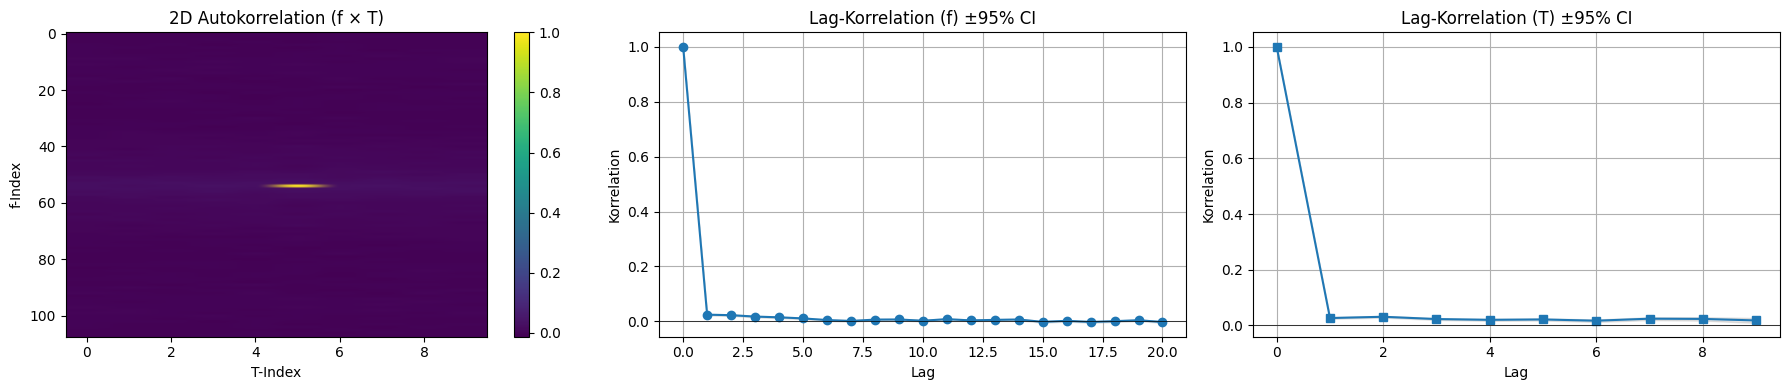

In [10]:
#### average hier über alle x-z werte für y = -1

y_idx = -1

slice_y = data_fT[:,y_idx,...]

noise = np.real(slice_y.reshape(-1, data.shape[-2], data.shape[-1]))

plot_noise_correlation_analysis(
    noise, x_label="T", y_label="f",
    max_lag_x=20, max_lag_y=20,
)

# tT correlations WITH low rank 8

Noise mean: 4.0154e-03, std: 3.3270e-02


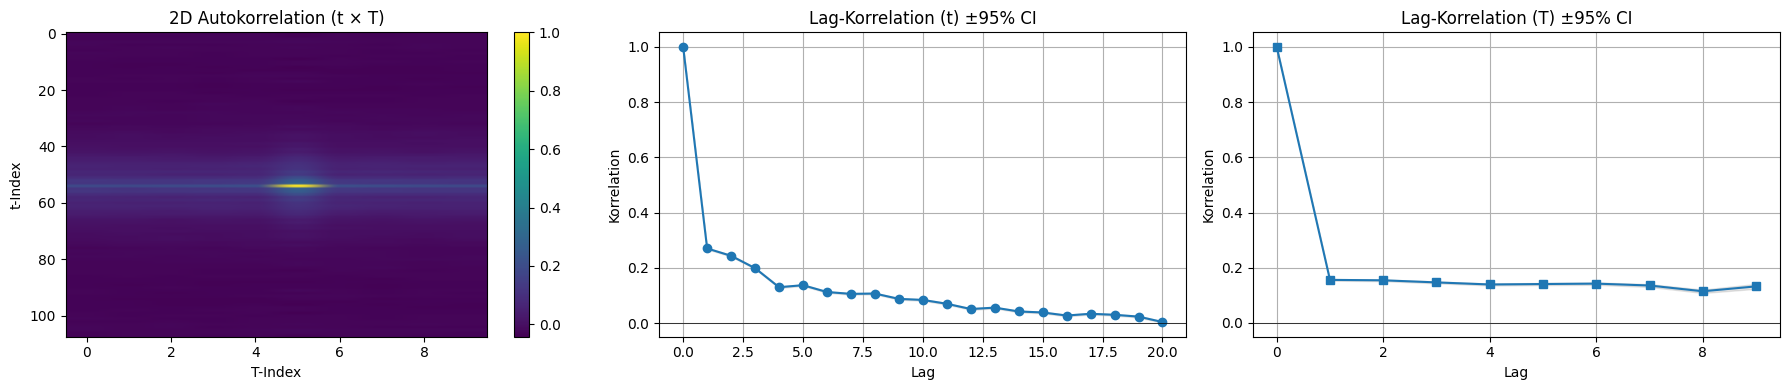

In [11]:
#### average hier über alle x-z werte für y = -1

y_idx = -1

slice_y = data_LR8[:,y_idx,...]

noise = np.real(slice_y.reshape(-1, data.shape[-2], data.shape[-1]))

plot_noise_correlation_analysis(
    noise, x_label="T", y_label="t",
    max_lag_x=20, max_lag_y=20,
)

# fT correlations WITH low rank 8

Noise mean: 6.1738e-02, std: 3.3997e-01


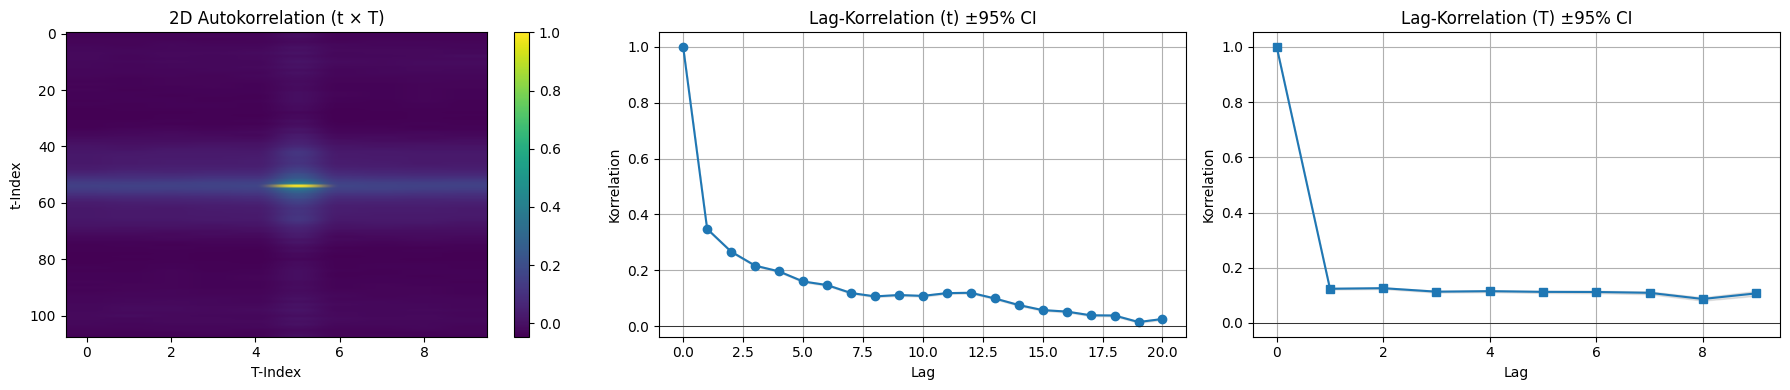

In [12]:
#### average hier über alle x-z werte für y = -1

y_idx = -1

slice_y = data_fT_LR8[:,y_idx,...]

noise = np.real(slice_y.reshape(-1, data.shape[-2], data.shape[-1]))

plot_noise_correlation_analysis(
    noise, x_label="T", y_label="t",
    max_lag_x=20, max_lag_y=20,
)

In [13]:
y_idx = -1

slice_y = data[:,y_idx,...]

x,z = 0,7

T1, T2 = 0, 5
spectrum_T1 = np.real(data[x, y_idx, z, :, T1])
spectrum_T2 = np.real(data[x, y_idx, z, :, T2])

prod = spectrum_T1 * spectrum_T2
mean_prod = prod.mean()
num_pos = np.sum(prod > 0)
num_neg = np.sum(prod < 0)

print(f"Mittelwert Produkt: {mean_prod:.4e}")
print(f"Anteil positiver Produkte: {num_pos / len(prod):.2%}")
print(f"Anteil negativer Produkte: {num_neg / len(prod):.2%}")


Mittelwert Produkt: 1.3497e-04
Anteil positiver Produkte: 50.00%
Anteil negativer Produkte: 50.00%


# fT - Lag correlation between low rank noise and full rank noise

LR noise mean: 6.1738e-02, std: 3.3997e-01
Full rank noise mean: 6.4427e-02, std: 9.1828e-01


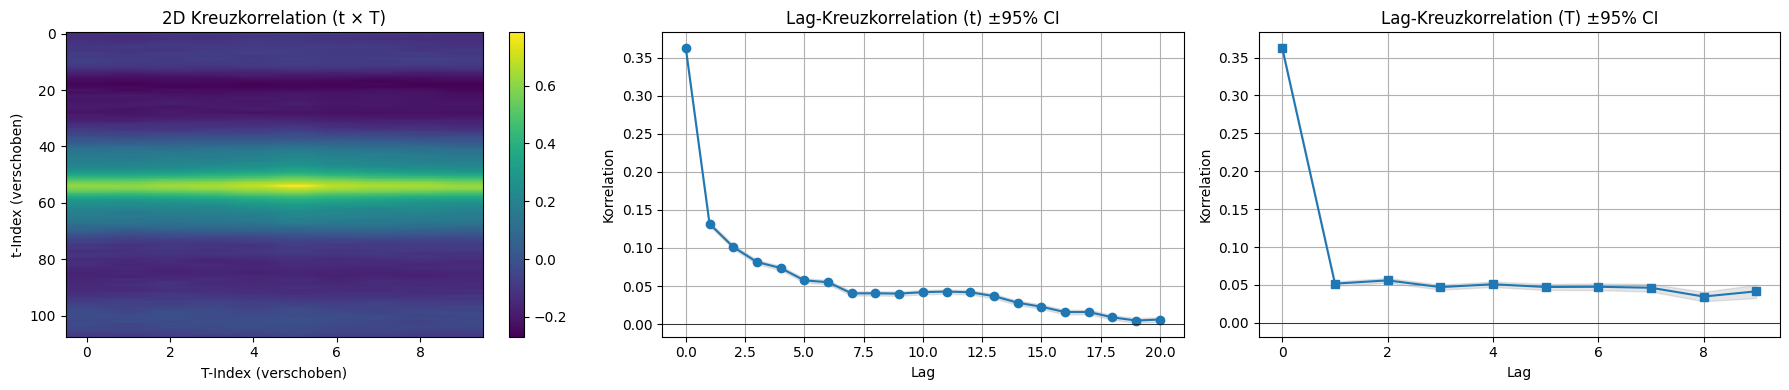

In [14]:
y_idx = -1

slice_y = data_fT_LR8[:,y_idx,...]

noise_LR = np.real(slice_y.reshape(-1, data.shape[-2], data.shape[-1]))

slice_y_2 = data_fT[:,y_idx,...]

noise = np.real(slice_y_2.reshape(-1, data.shape[-2], data.shape[-1]))

plot_cross_noise_correlation_analysis(
    noise_LR, noise, ('LR noise', 'Full rank noise'), x_label="T", y_label="t",
    max_lag_x=20, max_lag_y=20,
)

# tT - Lag correlation between low rank noise and full rank noise

LR noise mean: 4.0154e-03, std: 3.3270e-02
Full rank noise mean: 3.8912e-03, std: 8.8487e-02


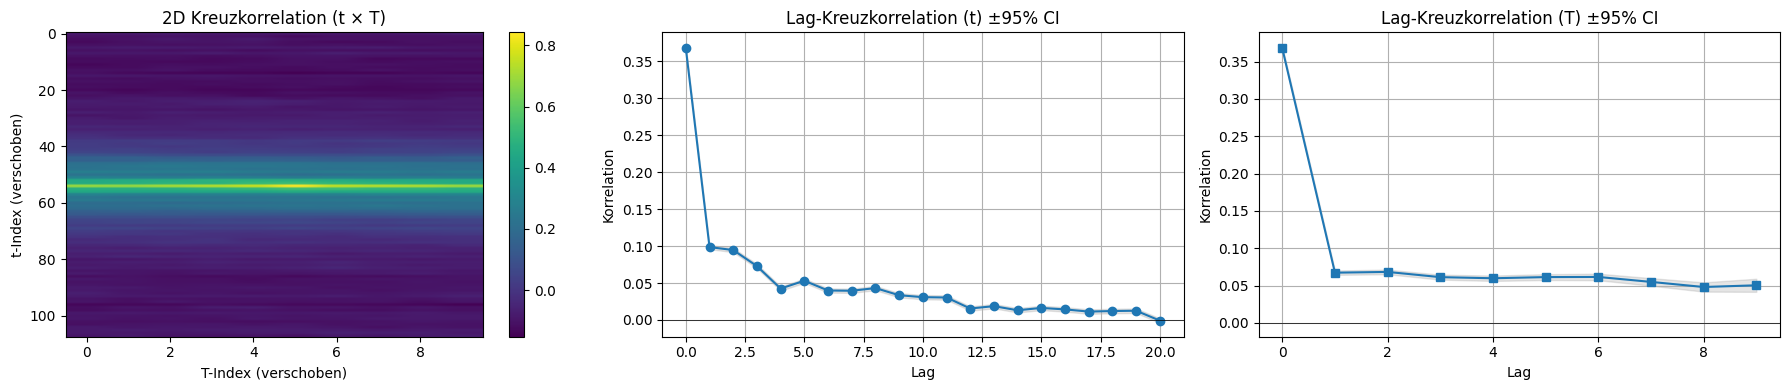

In [15]:
y_idx = -1

slice_y = data_LR8[:,y_idx,...]

noise_LR = np.real(slice_y.reshape(-1, data.shape[-2], data.shape[-1]))

slice_y_2 = data[:,y_idx,...]

noise = np.real(slice_y_2.reshape(-1, data.shape[-2], data.shape[-1]))

plot_cross_noise_correlation_analysis(
    noise_LR, noise, ('LR noise', 'Full rank noise'), x_label="T", y_label="t",
    max_lag_x=20, max_lag_y=20,
)

# Korrelation Real und Imaginärteil Full Rank Daten

noise real mean: 1.2899e+02, std: 3.3786e+04
noise imaginary mean: -1.5747e+03, std: 3.3718e+04


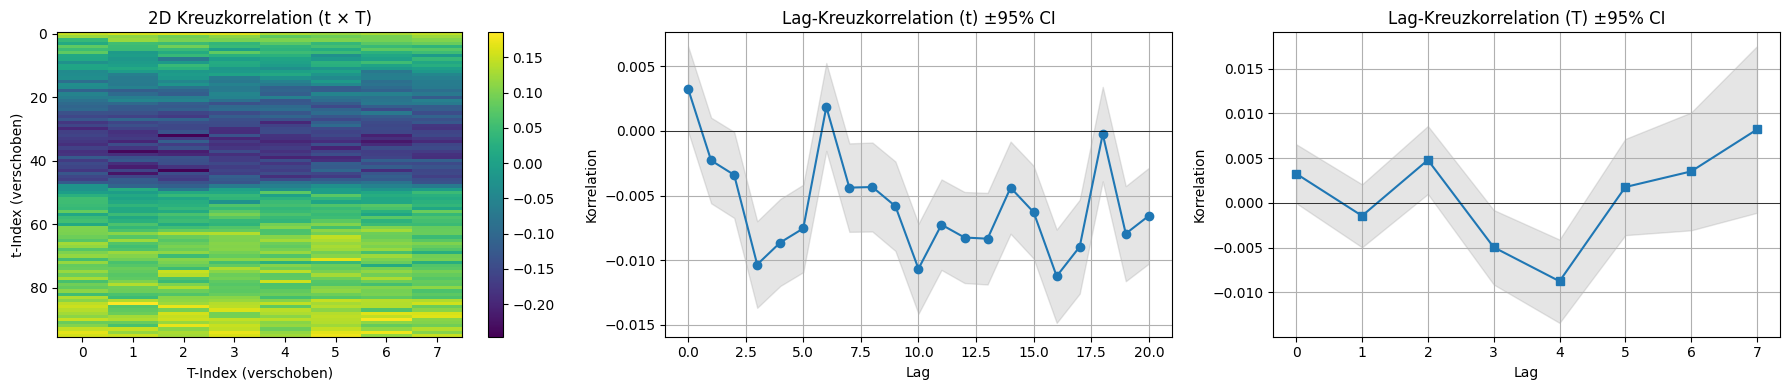

In [13]:
y_idx = -1

slice_y = data_fT[:,y_idx,...]

noise_real = np.real(slice_y.reshape(-1, data.shape[-2], data.shape[-1]))

noise_img = np.imag(slice_y.reshape(-1, data.shape[-2], data.shape[-1]))

plot_cross_noise_correlation_analysis(
    noise_real, noise_img, ('noise real', 'noise imaginary'), x_label="T", y_label="t",
    max_lag_x=20, max_lag_y=20,
)



# Check ob signal stärker in Zeitrichtung oder in frequenz richtung sich ändert, um optimale Tauschpartner zu finden

In [14]:
# data: (X,Y,Z,F,T) complex
# mask: (X,Y,Z) bool
mag = np.abs(data_fT).astype(np.float32)

# Maske auf (X,Y,Z,F,T) ausdehnen
mask_full = np.broadcast_to(mask[..., None, None], mag.shape)

# Finite Differenzen
diff_f = np.abs(mag[..., 1:, :] - mag[..., :-1, :])    # (X,Y,Z,F-1,T)
diff_t = np.abs(mag[..., :, 1:] - mag[..., :, :-1])    # (X,Y,Z,F,T-1)

# Paar-Masken: beide Voxel müssen im Gehirn liegen
pair_mask_f = mask_full[..., 1:, :] & mask_full[..., :-1, :]
pair_mask_t = mask_full[..., :, 1:] & mask_full[..., :, :-1]

# Gewichtete Mittel über Raumachsen
num_f = np.sum(diff_f * pair_mask_f, axis=(0,1,2))
den_f = np.sum(pair_mask_f,           axis=(0,1,2))
df_map = np.where(den_f>0, num_f/den_f, np.nan)        # (F-1, T)

num_t = np.sum(diff_t * pair_mask_t, axis=(0,1,2))
den_t = np.sum(pair_mask_t,           axis=(0,1,2))
dt_map = np.where(den_t>0, num_t/den_t, np.nan)        # (F, T-1)


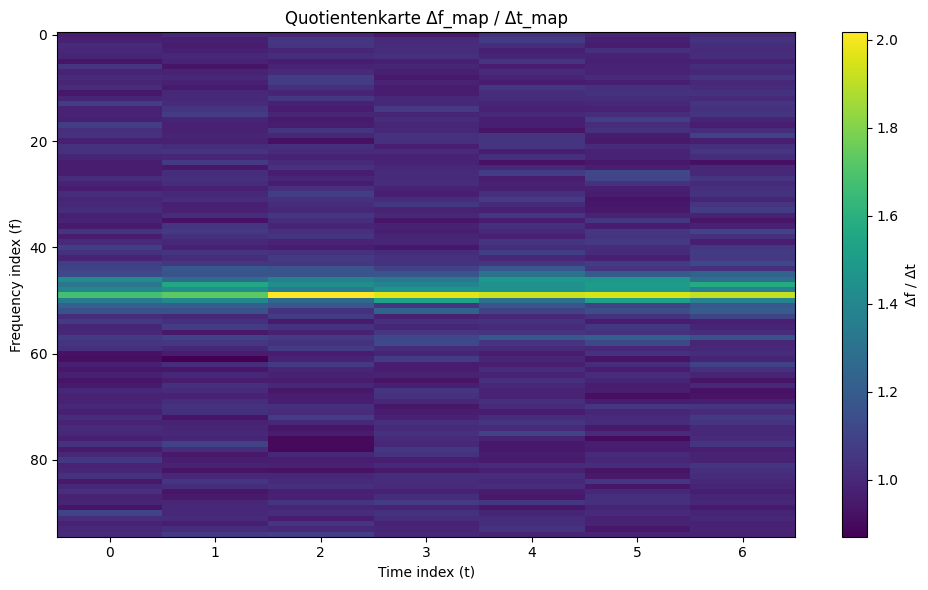

In [15]:
def plot_df_dt_quotient(df_map, dt_map):
    """
    Plots a quotient map of df_map and dt_map.
    df_map: array of shape (F-1, T)
    dt_map: array of shape (F, T-1)
    
    The quotient_map is computed over the overlapping region:
      quotient_map[f, t] = df_map[f, t] / dt_map[f, t]
    resulting in shape (F-1, T-1).
    """
    # Compute quotient
    quotient_map = df_map[:, :-1] / dt_map[:-1, :]
    
    # Plot
    plt.figure(figsize=(10, 6))
    im = plt.imshow(quotient_map, aspect='auto', cmap='viridis')
    plt.colorbar(im, label='Δf / Δt')
    plt.title('Quotientenkarte Δf_map / Δt_map')
    plt.xlabel('Time index (t)')
    plt.ylabel('Frequency index (f)')
    plt.tight_layout()
    plt.show()

plot_df_dt_quotient(df_map, dt_map)

### Neue Idee: Low rank nur x*y*z,f, und das T Mal: Damit bleibt noise unkorreliert entlang T, dann masken replizieren entlang f und z etc

In [5]:
import numpy as np
from numpy.fft import fft2, ifft2, fftshift
from scipy.stats import norm
import matplotlib.pyplot as plt
import os

import numpy as np


def low_rank_5d_proT(data: np.ndarray, rank: int) -> np.ndarray:
    """
    Low-Rank pro T: Für jedes T separat SVD auf (x*y*z, t),
    T wird NICHT gemischt.

    Args:
        data: Array mit Shape (x, y, z, t, T)
        rank: Anzahl der zu behaltenden Singulärwerte (hartes Truncation)

    Returns:
        Rekonstruiertes Array gleicher Shape.
    """
    if data.ndim != 5:
        raise ValueError(f"Expected 5D array (x,y,z,t,T), got {data.ndim}D")

    x, y, z, t, T = data.shape
    out = np.empty_like(data)

    for Ti in range(T):
        # Slice für aktuelles T: Shape (x, y, z, t)
        X = data[..., Ti]

        # (x*y*z, t) mit Fortran-Order (MATLAB-kompatibel)
        M = X.reshape((x * y * z, t), order='F')

        # Economy-SVD
        U, S, Vh = np.linalg.svd(M, full_matrices=False)

        # Trunkierung
        k = min(rank, S.size)
        S_trunc = np.zeros_like(S)
        S_trunc[:k] = S[:k]

        # Rekonstruktion
        M_rec = (U * S_trunc) @ Vh

        # Zurück in (x, y, z, t)
        out[..., Ti] = M_rec.reshape((x, y, z, t), order='F')

    return out


Vol = 'Tumor_2_normalized'

# Beispiel-Nutzung
#mask = np.load(f'../datasets/{Vol}/mask.npy')
data = np.load(f'../datasets/{Vol}/data.npy')

rank = 40
# Low-Rank nur über (x*y*z, t) pro T (kein T-Mischen)
data_LR = low_rank_5d_proT(data, rank=rank)

out_dir = f'../datasets/{Vol}_proTLR{rank}'
os.makedirs(out_dir, exist_ok=True)  # erstellt alle fehlenden Ordner

np.save(f'{out_dir}/data.npy', data_LR)

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def compute_time_autocorrelation(noise: np.ndarray, max_lag: int = 20):
    """
    1D-Autokorrelation entlang der T-Achse, gemittelt über Frequenz (und ggf. N).
    
    Args
    ----
    noise : np.ndarray
        - Shape (F, T)    -> Einzelbild
        - Shape (N, F, T) -> Stapel von Bildern
    max_lag : int
        Maximale Verzögerung.

    Returns
    -------
    lags : np.ndarray
        Lags 0..max_lag
    corr : np.ndarray
        Autokorrelation (normiert) pro Lag, gemittelt über Bilder
    n_tot: np.ndarray
        Anzahl der verwendeten Paarungen je Lag (für Konfidenzband)
    """
    if noise.ndim == 2:
        imgs = noise[None]  # -> (1, F, T)
    elif noise.ndim == 3:
        imgs = noise
    else:
        raise ValueError("noise must be 2-D (F,T) or 3-D (N,F,T)")

    F, T = imgs.shape[-2:]
    ML = min(max_lag, T - 1)
    lags  = np.arange(ML + 1)
    corr  = np.zeros_like(lags, dtype=np.float64)
    n_tot = np.zeros_like(lags, dtype=np.int64)

    for img in imgs:
        # Zentrieren (wie in deinem _center)
        x   = img.astype(np.float32) - img.mean(dtype=np.float64)
        var = x.var(dtype=np.float64)
        if var == 0:
            raise ValueError("Varianz ist 0 – Korrelation undefiniert.")

        for i, k in enumerate(lags):
            a, b   = x[:, 0:T-k], x[:, k:T]     # über T verschoben
            prod   = (a * b).mean()             # Mittel über F und T-Paare
            corr[i] += prod / var
            n_tot[i] += a.size                   # F * (T-k)

    corr /= len(imgs)  # Mittelwert über N
    return lags, corr, n_tot


def plot_time_autocorrelation(
    noise: np.ndarray,
    max_lag: int = 20,
    title: str = "Autokorrelation entlang T",
    xlabel: str = "Lag (T)",
    ylabel: str = "Korrelation",
    show_ci: bool = True,
    alpha_ci: float = 0.2
):
    """
    Plottet die 1D-Autokorrelation entlang T inkl. 95%-Konfidenzband (±z/sqrt(N)).
    Nutzt deine vorhandene confidence_band(n_pairs).
    """
    # Statistiken
    nf = noise.reshape(-1)
    print(f"Noise mean: {nf.mean():.4e}, std: {nf.std():.4e}")

    # ACF entlang T
    lags, corr, n_pairs = compute_time_autocorrelation(noise, max_lag=max_lag)

    # CI aus deiner Funktion
    try:
        band = confidence_band(n_pairs) if show_ci else None
    except NameError:
        band = None  # falls confidence_band nicht im Scope ist

    # Plot
    plt.figure(figsize=(6, 4))
    plt.plot(lags, corr, "o-", label="Autokorrelation (T)")
    if show_ci and band is not None:
        plt.fill_between(lags, corr - band, corr + band, alpha=alpha_ci)
    plt.axhline(0, color="k", lw=0.5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
